In [ ]:
import yfinance as yf

In [449]:
df=yf.download('AAPL',start='2014-12-03',end='2025-06-10')
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2014-12-03,25.754827,25.848134,25.572658,25.714839,172253600
2014-12-04,25.657072,26.036963,25.612641,25.719276,168178000
2014-12-05,25.548222,25.788153,25.468244,25.768158,153275600
2014-12-08,24.970612,25.470468,24.797328,25.348280,230659600
2014-12-09,25.352720,25.392709,24.293024,24.479638,240832000


In [450]:
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

In [451]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2644 entries, 2014-12-03 to 2025-06-09
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2644 non-null   float64
 1   High    2644 non-null   float64
 2   Low     2644 non-null   float64
 3   Close   2644 non-null   float64
 4   Volume  2644 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 123.9 KB


In [452]:
import numpy as np
import pandas as pd
df['Return']=np.log(df['Close'] / df['Close'].shift(1))
df['Ma_5'] = df['Close'].rolling(window=5).mean()
df['Ma_20'] = df['Close'].rolling(window=20).mean()
df['Volatility_5']=df['Return'].rolling(window=5).std()
df['Target'] = df['Close'].shift(-1)

In [453]:
features = ['Open', 'High', 'Low','Volume','Return','Ma_5','Ma_20','Volatility_5']

In [455]:
df.dropna(inplace=True)

In [456]:
df.head(10)

,Open,High,Low,Close,Volume,Return,Ma_5,Ma_20,Volatility_5,Target
Date,,,,,,,,,,
2014-12-31,24.521847,25.132782,24.484080,25.063914,165613600,-0.007242,25.100791,24.965831,0.009040,24.746224
2015-01-02,24.288578,24.757332,23.848704,24.746224,212818400,-0.012756,25.047916,24.917400,0.010446,24.057541
2015-01-05,23.604338,24.137518,23.417725,24.057541,257142000,-0.028224,24.878633,24.834313,0.015798,23.668754
2015-01-06,23.606550,23.866475,23.244431,23.668754,263188400,-0.016293,24.556502,24.729343,0.010151,23.815387
2015-01-07,23.937574,24.037545,23.704307,23.815387,160423600,0.006176,24.270364,24.652698,0.012597,24.266367
2015-01-08,24.857307,24.915069,24.148621,24.266367,237458000,0.018759,24.110855,24.642035,0.018746,25.030594
2015-01-09,24.883970,25.159446,24.484084,25.030594,214798000,0.031008,24.167729,24.622707,0.024431,25.015044
2015-01-12,24.270813,25.021708,24.170842,25.015044,198603200,-0.000621,24.359229,24.626484,0.018116,24.755121
2015-01-13,24.486309,25.059478,24.195282,24.755121,268367600,-0.010445,24.576502,24.637259,0.016265,24.224155


In [457]:
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

In [459]:
# Features
scaler = MinMaxScaler()
scaler.fit(train_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'Ma_5', 'Ma_20', 'Volatility_5']])

train_scaled = scaler.transform(train_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'Ma_5', 'Ma_20', 'Volatility_5']])
test_scaled = scaler.transform(test_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'Ma_5', 'Ma_20', 'Volatility_5']])

# Convert back to DataFrames if needed
train_scaled_df = pd.DataFrame(train_scaled, columns=scaler.feature_names_in_, index=train_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=scaler.feature_names_in_, index=test_df.index)

# Target
close_scaler = MinMaxScaler()
close_scaler.fit(train_df[['Target']])

train_target = close_scaler.transform(train_df[['Target']])
test_target = close_scaler.transform(test_df[['Target']])

In [460]:
x_train = train_scaled_df.values.reshape((train_scaled_df.shape[0], 1, train_scaled_df.shape[1]))  # (no_of_values, timestamps , features)
x_test = test_scaled_df.values.reshape((test_scaled_df.shape[0], 1, test_scaled_df.shape[1]))     # (n_test, 1, 8)

y_train= train_target
y_test=test_target

In [461]:
x_train.shape

(2099, 1, 9)

In [464]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.optimizers import Adam

In [469]:
model = Sequential()
model.add(LSTM(units=512, return_sequences=False, input_shape=(1,9)))
model.add(Dropout(0.01))
model.add(Dense(units=1))

In [470]:
optimizer=Adam(learning_rate=0.002)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [471]:
history = model.fit(x_train, y_train, epochs=200, batch_size=32)

Epoch 1/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0329
Epoch 2/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.7508e-04
Epoch 3/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.3784e-04
Epoch 4/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.1720e-04
Epoch 5/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.1649e-04
Epoch 6/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.2033e-04
Epoch 7/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.1308e-04
Epoch 8/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.0351e-04
Epoch 9/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.4988e-05
Epoch 10/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.0078e-04
Epoch 11/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.0882e-04
Epoch 12/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 8.8752e-05
Epoch 13/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.0745e-04
Epoch 14/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 9.6117e-05
Epoch

In [472]:
pred = model.predict(x_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [473]:
print(pred.shape)
print(y_test.shape)

(525, 1)
(525, 1)


In [474]:
pred_inverse = close_scaler.inverse_transform(pred)
y_test_true = close_scaler.inverse_transform(y_test)

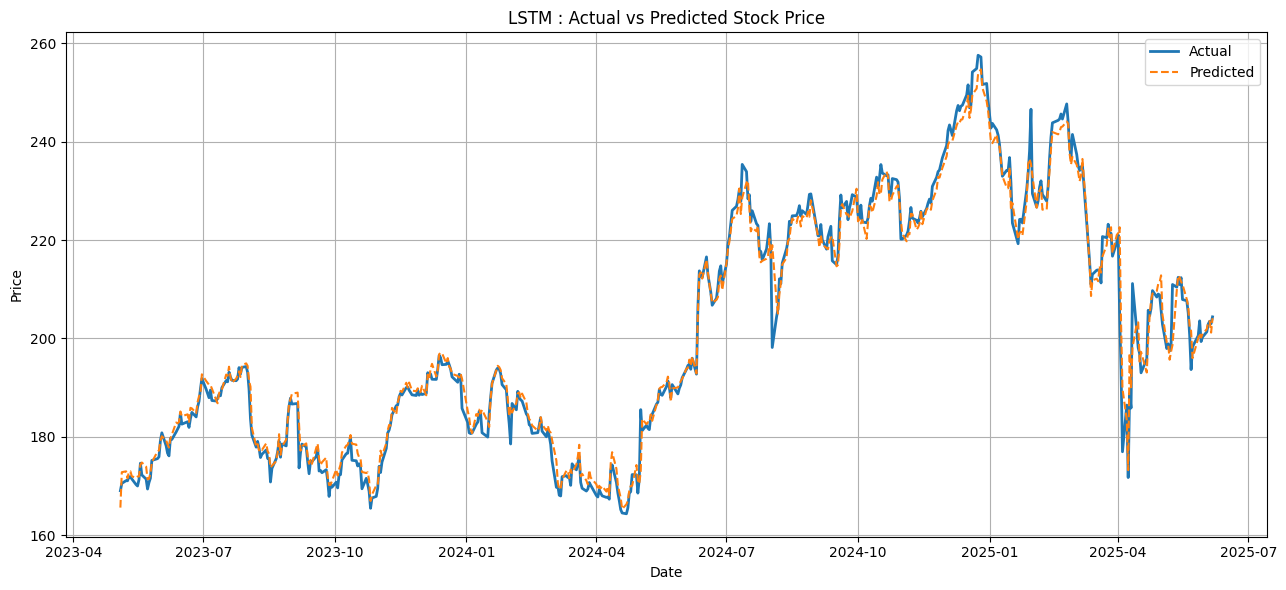

In [475]:
import matplotlib.pyplot as plt

test_dates = df.index[-len(y_test):]
plt.figure(figsize=(13,6))
plt.plot(test_dates, y_test_true.flatten(), label='Actual', linewidth=2)
plt.plot(test_dates, pred_inverse.flatten(), label='Predicted', linestyle='--')
plt.title('LSTM : Actual vs Predicted Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [476]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_true, pred_inverse)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_true, pred_inverse)
r2 = r2_score(y_test_true, pred_inverse)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R² Score:", r2)

MSE: 7.269652983356232
RMSE: 2.696229401100031
MAE: 1.7791093039742911
R² Score: 0.9877378899685503


# MICRON STOCKS

In [477]:
df2=yf.download('MU',start='2010-12-9')
df2.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MU,MU,MU,MU,MU
Date,,,,,
2010-12-09,8.006721,8.143589,7.918736,8.143589,30057700
2010-12-10,8.065377,8.133810,7.889405,8.016496,31090800
2010-12-13,7.957841,8.192470,7.957841,8.192470,28082700
2010-12-14,7.889407,8.006722,7.820974,7.967617,25962700
2010-12-15,7.742763,7.928510,7.703658,7.820972,20301400


In [478]:

df2.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# 📌 Step 2: Feature engineering (same as training)
df2['Return'] = np.log(df2['Close'] / df2['Close'].shift(1))
df2['Ma_5'] = df2['Close'].rolling(window=5).mean()
df2['Ma_20'] = df2['Close'].rolling(window=20).mean()
df2['Volatility_5'] = df2['Return'].rolling(window=5).std()
df2['Target'] = df2['Close'].shift(-1)

df2.dropna(inplace=True)

# 📌 Step 3: Use the same features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'Ma_5', 'Ma_20', 'Volatility_5']

# ✅ Step 4: Scale features using the **original feature scaler**
scaled_df2 = pd.DataFrame(scaler.transform(df2[features]), columns=features, index=df2.index)

# ✅ Step 5: Prepare X and y for the new stock
X_new = scaled_df2[features].values
y_new = df2['Target'].values.reshape(-1, 1)

# Reshape X for LSTM
X_new = X_new.reshape((X_new.shape[0], 1, X_new.shape[1]))

In [479]:
pred2=model.predict (X_new)

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [480]:
pred2 = close_scaler.inverse_transform(pred2)
y = close_scaler.inverse_transform(y)

In [481]:
print(pred2.shape)
print(y.shape)

(3629, 1)
(3629, 1)


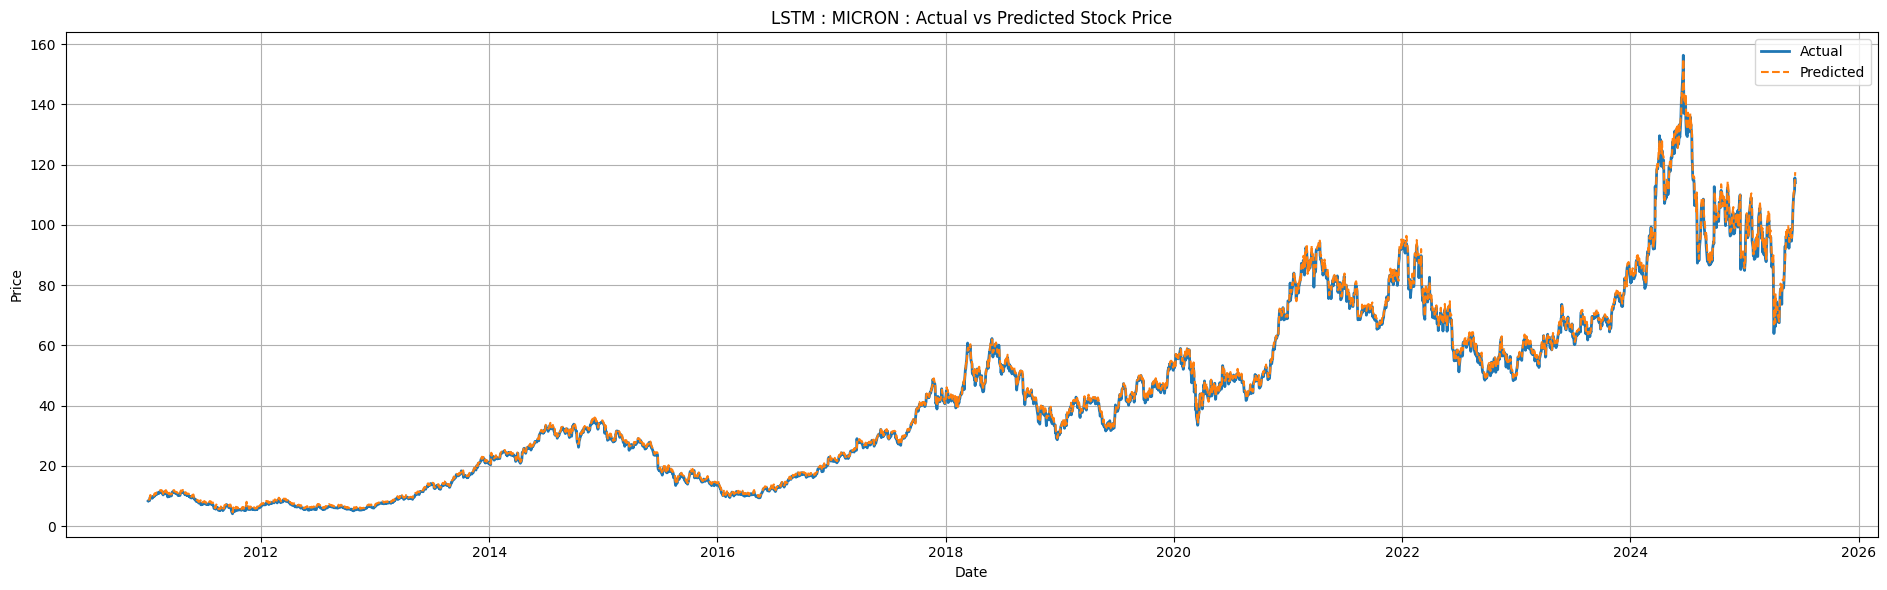

In [482]:
import matplotlib.pyplot as plt

test_dates = df2.index
plt.figure(figsize=(19,6))
plt.plot(test_dates, y_new.flatten(), label='Actual', linewidth=2)
plt.plot(test_dates, pred2.flatten(), label='Predicted', linestyle='--')
plt.title('LSTM : MICRON : Actual vs Predicted Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [483]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_new, pred2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_new, pred2)
r2 = r2_score(y_new, pred2)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R² Score:", r2)

MSE: 1.6307893434525935
RMSE: 1.2770236268184678
MAE: 0.8414269010802905
R² Score: 0.9982297360833974
